## **2. Stochastic optimal stopping LQR**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are, solve_lyapunov, eigvals, norm, solve_continuous_lyapunov
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

Consider a continuous-time risk-sensitive LQR problem, in which dynamics of $x$ follows:

$$dx_t = (Ax_t + Bu_t)dt + Gdw_t$$

where $x_t \in \mathbb{R}^n$, $u_t \in \mathbb{R}^m$, $w_t$ is a standard $r$-dimensional Wiener process and $G \in \mathbb{R}^{n \times r}$.

The stochastic optimal stopping LQR problem is to minimize the cost function:

$$J(u, \tau) = \mathbb{E}\left[\int_0^\tau e^{-\rho t}\left(x(t)^TQx(t) + u(t)^TRu(t)\right)dt + e^{-\rho\tau}x(\tau)^TSx(\tau)\right]$$

by choosing optimal control $u_t$ and an optimal stopping time $\tau$. The value function $V(x)$ satisfies the stochastic HJB variational inequality:

$$\min\left\{\rho V(x) - \min_u\left[x^TQx + u^TRu + \nabla V(x)^T(Ax + Bu) + \frac{1}{2}\text{Tr}(GG^T\nabla^2V(x))\right], V(x) - x^TSx\right\} = 0$$

The solution to the above problem is:

$$V(x) = \begin{cases}
x^TPx, & x \in \text{ the continuation region } C = \mathbb{R}^m \setminus S \\
x^TSx, & x \in \text{ the stopping region } S
\end{cases}$$

This means that, for $x \in C$, apply $u^*(x)$, and for $x \in S$, stop immediately: $\tau = 0$.

In the continuation region $C$, the optimal control is linear:

$$u^*(x) = -R^{-1}B^TPx$$

and the matrix $P$ satisfies the stochastic Riccati equation:

$$A^TP + PA - PBR^{-1}B^TP + Q - \rho P + PGG^TP = 0$$

The stopping region is given by:

$$S = \{x \in \mathbb{R}^n : x^TPx \leq x^TSx\}$$

The boundary of $S$ which solves the equation $x^TPx \leq x^TSx$ is called the stopping boundary. Since the stopping boundary is a function of $x$, we denote it by $b(x)$.

Consider the problem with parameters:

$$\rho = 0.1, \quad A = \begin{bmatrix}0 & 1 \\ -2 & -3\end{bmatrix}, \quad B = \begin{bmatrix}0 \\ 1\end{bmatrix}, \quad G = \begin{bmatrix}0.1 & 0 \\ 0 & 0.1\end{bmatrix}, \quad Q = \begin{bmatrix}1 & 0 \\ 0 & 1\end{bmatrix}, \quad R = [1]$$

and $S = I_2$, solve the following problem:

**(a)** Use the analytical result above to compute the value function $V(x)$, optimal control $u$, and the stopping boundary $b(x)$.

To find the value function $V(x)$ we need to solve first the stochastic Riccati equation to obtain $P$

In [3]:
# System parameters
rho = 0.1
A = np.array([[0, 1], [-2, -3]])
B = np.array([[0], [1]])
G = np.array([[0.1, 0], [0, 0.1]])
Q = np.array([[1, 0], [0, 1]])
R = np.array([[1]])
S = np.eye(2)  # S = I_2

GGt = G @ G.T
R_inv = np.linalg.inv(R)

# Solve Riccati equation

def solve_stochastic_riccati(A, B, R, Q, G, rho,
                            tol=1e-9, maxiter=50, verbose=False):
    '''Solves the stochastic Riccati equation iteratively
    Inputs: A, B, Q, G are numpy arrays; R is assumed symmetric posdef scalar/matrix
    '''
    n = A.shape[0]
    I = np.eye(n)
    A_discounted = A - 0.5 * rho * I

    # Initial guess: solve CARE ignoring the P GG^T P term
    try:
        Pk = solve_continuous_are(A_discounted, B, Q, R)
    except Exception:
        # fallback initial guess
        Pk = Q.copy()

    def F(P):
        return (A_discounted.T @ P + P @ A_discounted
                - P @ B @ np.linalg.inv(R) @ B.T @ P
                + Q + P @ G @ G.T @ P)

    for k in range(maxiter):
        Fk = F(Pk)
        err = norm(Fk, ord='fro')
        if verbose:
            print(f"iter {k}: ||F(Pk)||_F = {err:.3e}")
        if err < tol:
            print(f"Converged after {k + 1} iterations")
            return Pk

        # Build closed-loop matrix for linearization
        BRB = B @ np.linalg.inv(R) @ B.T   # B R^{-1} B^T
        Acl = A_discounted - BRB @ Pk + (G @ G.T) @ Pk

        # Solve Lyapunov: Acl^T Δ + Δ Acl = -F(Pk) 
        # scipy solver expects A X + X A^T = Q; we adapt by transposing
        # Solve (Acl^T) Δ + Δ (Acl) = -Fk  =>  (Acl) Δ^T + Δ^T (Acl)^T = -Fk^T
        # but we can use solve_continuous_lyapunov on Acl and right-hand side:
        # solve_continuous_lyapunov(Acl.T, -Fk) returns Δ
        try:
            Delta = solve_continuous_lyapunov(Acl.T, -Fk)
        except Exception as e:
            raise RuntimeError("Lyapunov solve failed in Newton step: " + str(e))

        Pk = Pk + Delta

    raise RuntimeError("Newton iteration did not converge within maxiter")

P = solve_stochastic_riccati(A, B, R, Q, G, rho, verbose=True)
P_analytical = P

iter 0: ||F(Pk)||_F = 1.425e-02
iter 1: ||F(Pk)||_F = 8.643e-06
iter 2: ||F(Pk)||_F = 2.949e-12
Converged after 3 iterations


In [4]:
# We can check that indeed our solution is optimal:
A.T @ P + P @ A - P @ B @ R_inv @ B.T @ P + Q - rho * P + P @ GGt @ P

array([[-2.54698519e-12, -1.01155716e-12],
       [-1.01155672e-12, -4.01755777e-13]])

We know that in the continuation region $C$, our optimal solution is given by

$$u^*(x) = -R^{-1}B^TPx$$

which is equivalent to

$$u^*(x) = -Kx$$

In [5]:
K = np.linalg.inv(R) @ B.T @ P
K

array([[0.21316998, 0.22563788]])

In [6]:
# Stopping region: {x: xᵀPx ≤ xᵀSx} = {x: xᵀ(P-S)x ≤ 0}
P_minus_S = P - S
print(f"P - S = \n{P_minus_S}")

eigvals = np.linalg.eigvals(P_minus_S)
print(f"Eigenvalues of (P-S): {eigvals}")

P - S = 
[[ 0.15725402  0.21316998]
 [ 0.21316998 -0.77436212]]
Eigenvalues of (P-S): [ 0.20371405 -0.82082215]


In [7]:
def exact_solution(P_analytical, S, K_analytical, x_range=(-2, 2), grid_points=50):
    """Find analytical solution for each point in the domain"""
    
    # Create test grid
    x1 = np.linspace(x_range[0], x_range[1], grid_points)
    x2 = np.linspace(x_range[0], x_range[1], grid_points)
    
    # Make a grid of X1 and X2 coordinates
    X1, X2 = np.meshgrid(x1, x2, indexing='ij')
    # Merge both grids in coordinate pairs, shape = (2500, 2) = (gridpoints², 2)
    x_test_np = np.stack([X1.ravel(), X2.ravel()], axis=1)

    # Analytical solutions and continuation / stopping regions
    V_analytical = []
    u_analytical = []
    continuation_region = []
    stopping_region = []
    
    for x in x_test_np:
        V_continue = x.T @ P_analytical @ x
        V_stop = x.T @ S @ x
        
        V_x = min(V_continue, V_stop)
        V_analytical.append(V_x)
        
        # Check if the point is in the stopping region
        if (V_continue < V_stop):
            continuation_region.append(x)
            u_analytical.append((-K_analytical @ x) * np.ones_like(x))  # u = -Kx
        # Continuation region
        else:
            stopping_region.append(x)
            u_analytical.append(np.zeros_like(x))
    
    # Reshape for plotting
    V_analytical_grid = np.array(V_analytical).reshape(grid_points, grid_points)
    u_analytical_grid = np.array(u_analytical).T.reshape(2, grid_points, grid_points)
    
    return {
        'x1': X1, 'x2': X2,
        'V_analytical': V_analytical_grid, 
        'u_analytical': u_analytical_grid,
        'Regions': [continuation_region, stopping_region]
    }

def plot_solution(exact_results, P, S):
    """Create comprehensive comparison plots"""
    
    X1, X2 = exact_results['x1'], exact_results['x2']
    
    fig = plt.figure(figsize=(10, 10))
    
    # 1. Value Function Comparison
    
    # Analytical solution for V
    plt.subplot(2, 2, 1)
    contour = plt.contourf(X1, X2, exact_results['V_analytical'], levels=50)
    plt.colorbar(contour)
    plt.xlabel(r'$x_1$', fontsize=15)
    plt.ylabel(r'$x_2$', fontsize=15)
    plt.title(r'Analytical $V(x)$')
    
    # 2. Control Policy Comparison
    
    # Analytical solution for u
    plt.subplot(2, 2, 2)
    contour = plt.contourf(X1, X2, exact_results['u_analytical'][0], levels=50)
    plt.colorbar(contour)
    plt.xlabel(r'$x_1$', fontsize=15)
    plt.ylabel(r'$x_2$', fontsize=15)
    plt.title(r'Analytical $u(x)$')
    
    # 3. 3D Surface Plots
    
    # 3D plot V(x) analytical
    ax = fig.add_subplot(2, 2, 3, projection='3d')
    ax.plot_surface(X1, X2, exact_results['V_analytical'], cmap='viridis', alpha=0.8)
    ax.set_title(r'Analytical $V(x)$ - 3D')
    ax.set_xlabel(r'$x_1$', fontsize=15)
    ax.set_ylabel(r'$x_2$', fontsize=15)
    
    # 4. Decision region
    
    ax = fig.add_subplot(2, 2, 4)
    continue_points = np.array(exact_results['Regions'][0])
    stop_points = np.array(exact_results['Regions'][1])

    # Scatter plot the regions
    ax.scatter(stop_points[:, 0], stop_points[:, 1], 
            c='orange', s=1, alpha=1, label='Stop', marker='o')
    ax.scatter(continue_points[:, 0], continue_points[:, 1], 
            c='lightblue', s=1, alpha=1, label='Continue')


    ax.set_title('Orange: Stop, Blue: Continue')
    ax.set_xlabel(r'$x_1$', fontsize=15)
    ax.set_ylabel(r'$x_2$', fontsize=15)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()
    
    return None

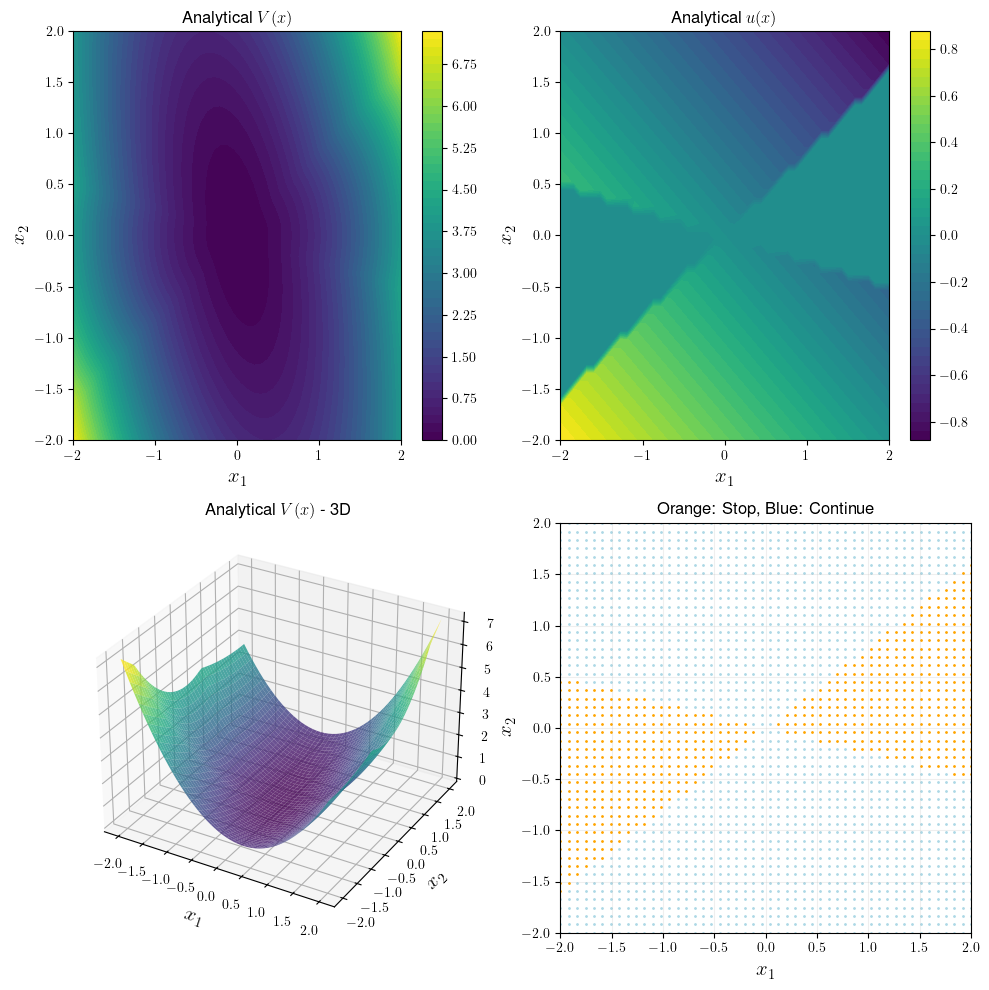

In [8]:
exact_solution = exact_solution(P, S, K)
plot_solution(exact_solution, P, S)

**(b)** Use the PINN method to solve the obtained equation for $V(x)$, $u$ and $b(x)$. Denote your solution by $\hat{V}(x)$ and $\hat{u}(x)$. (Hint: Construct two networks for $V(x)$ and $b(x)$, respectively).

In [9]:
# Common parameters from the homework
rho = 0.1
A = torch.tensor([[0., 1.], [-2., -3.]])
B = torch.tensor([[0.], [1.]])
G = torch.tensor([[0.1, 0.], [0., 0.1]])
Q = torch.tensor([[1., 0.], [0., 1.]])
R = torch.tensor([[1.]])
GG_T = G @ G.T

In [10]:
# Set default device and data type
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE = torch.float32
print(f"Using device: {DEVICE}")

# Common parameters from the homework
rho = 0.1
A = torch.tensor([[0., 1.], [-2., -3.]], dtype=DTYPE, device=DEVICE)
B = torch.tensor([[0.], [1.]], dtype=DTYPE, device=DEVICE)
G = torch.tensor([[0.1, 0.], [0., 0.1]], dtype=DTYPE, device=DEVICE)
Q = torch.tensor([[1., 0.], [0., 1.]], dtype=DTYPE, device=DEVICE)
R = torch.tensor([[1.]], dtype=DTYPE, device=DEVICE)
GG_T = G @ G.T

# PINN training parameters
N_train = 2000
learning_rate = 5e-3
epochs = 5000

# Helper function to compute the Hessian for a batch of inputs
def hessian(output, inputs):
    """Computes the Hessian of a scalar-valued function for a batch of inputs."""
    # output shape: (N, 1), inputs shape: (N, 2)
    grad_output = torch.autograd.grad(outputs=output.sum(), inputs=inputs, create_graph=True)[0]
    
    hess = []
    for i in range(inputs.shape[1]):
        # grad of each component of the grad_output
        grad_of_grad_i = torch.autograd.grad(outputs=grad_output[:, i].sum(), inputs=inputs, create_graph=True)[0]
        hess.append(grad_of_grad_i)
    
    return torch.stack(hess, dim=2) # Result shape: (N, 2, 2)

Using device: cpu


In [14]:
# Analytical Solution
A_np, B_np, Q_np, R_np = A.cpu().numpy(), B.cpu().numpy(), Q.cpu().numpy(), R.cpu().numpy()
A_tilde = A_np - (rho / 2) * np.eye(A_np.shape[0])
P_analytical = torch.tensor(P_analytical, dtype=DTYPE, device=DEVICE)
S = torch.eye(2, dtype=DTYPE, device=DEVICE)
print("Analytical P matrix for Problem 2:\n", P_analytical.numpy())

def V_analytical_2(x):
    return torch.einsum('bi,ij,bj->b', x, P_analytical, x)

# (b) PINN Method
# Define the PINN model for V(x)
class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

V_model_2 = ValueNetwork().to(DEVICE)
optimizer_2 = torch.optim.Adam(V_model_2.parameters(), lr=learning_rate)

# Training loop
domain_points = torch.rand((N_train, 2), device=DEVICE) * 4 - 2 # Points in [-2, 2]
domain_points.requires_grad = True

for epoch in range(epochs):
    optimizer_2.zero_grad()
    
    V = V_model_2(domain_points)
    grad_V = torch.autograd.grad(V.sum(), domain_points, create_graph=True)[0]
    hess_V = hessian(V, domain_points)

    # Hamiltonian for the continuation region
    hamiltonian = (torch.einsum('bi,ij,bj->b', domain_points, Q, domain_points) # x'Qx
                   - 0.25 * torch.einsum('bi,ij,bj->b', grad_V, B @ torch.inverse(R) @ B.T, grad_V)
                   + torch.einsum('bi,bi->b', grad_V, domain_points @ A.T) # gradV'Ax
                   + 0.5 * torch.einsum('bii->b', GG_T @ hess_V)) # 1/2 Tr(GG' Hessian)

    # Variational inequality terms
    f1 = rho * V.squeeze() - hamiltonian
    f2 = V.squeeze() - torch.einsum('bi,ij,bj->b', domain_points, S, domain_points)

    loss_pde = torch.mean((f1 * f2)**2)
    loss_ineq = torch.mean(torch.relu(-f1)**2 + torch.relu(f2)**2)
    loss = loss_pde + loss_ineq

    loss.backward()
    optimizer_2.step()
    
    if epoch % 500 == 0:
        print(f"Problem 2 - Epoch {epoch}: Loss = {loss.item()}")

Analytical P matrix for Problem 2:
 [[1.157254   0.21316999]
 [0.21316999 0.22563788]]
Problem 2 - Epoch 0: Loss = 222.18482971191406
Problem 2 - Epoch 500: Loss = 0.07166951149702072
Problem 2 - Epoch 1000: Loss = 0.03133003041148186
Problem 2 - Epoch 1500: Loss = 0.012628571130335331
Problem 2 - Epoch 2000: Loss = 0.007192113436758518
Problem 2 - Epoch 2500: Loss = 0.022839773446321487
Problem 2 - Epoch 3000: Loss = 0.0032205763272941113
Problem 2 - Epoch 3500: Loss = 0.013518402352929115
Problem 2 - Epoch 4000: Loss = 0.005636159330606461
Problem 2 - Epoch 4500: Loss = 0.004486419260501862


**(c)** Compare your results in (a) and (b).


Problem 2 - L1 Absolute Error: 5.6506e-01
Problem 2 - L1 Relative Error: 2.9130e+00



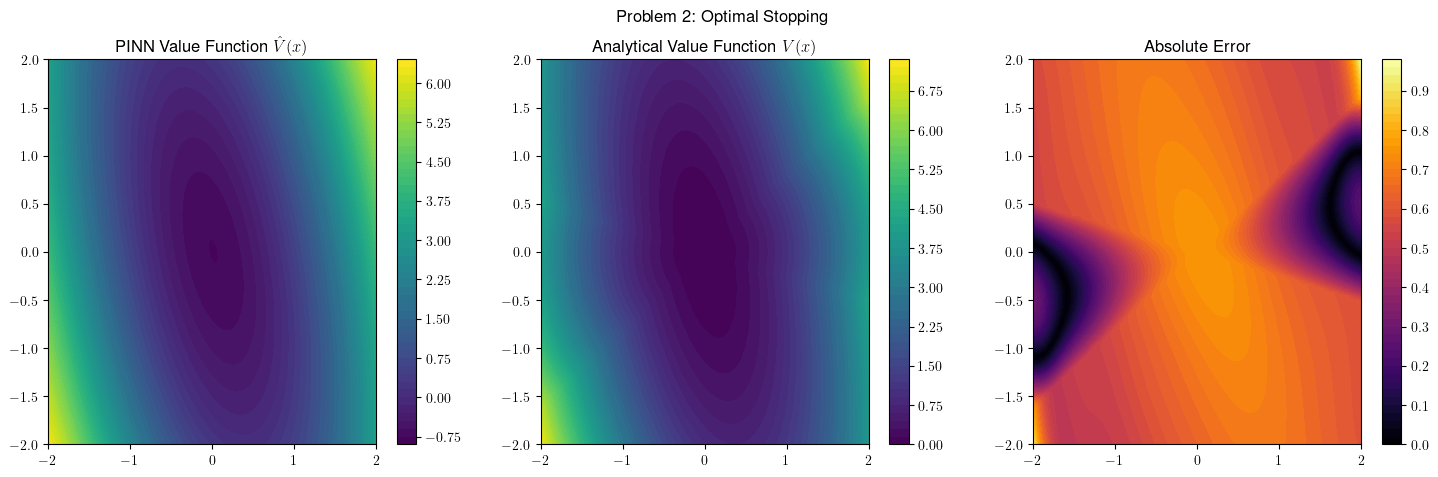

In [15]:
# Comparison
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
x_grid = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=DTYPE, device=DEVICE)

V_pinn_2 = V_model_2(x_grid).detach().cpu().numpy().squeeze()
V_true_2_cont = V_analytical_2(x_grid).detach().cpu().numpy()

# Determine stopping region
is_stopping = (torch.einsum('bi,ij,bj->b', x_grid, S - P_analytical, x_grid) <= 0).cpu().numpy()
V_true_2 = V_true_2_cont
V_true_2[is_stopping] = torch.einsum('bi,ij,bj->b', x_grid[is_stopping], S, x_grid[is_stopping]).cpu().numpy()

abs_error_l1 = np.mean(np.abs(V_pinn_2 - V_true_2))
rel_error_l1 = np.mean(np.abs(V_pinn_2 / V_true_2 - 1.0))
print(f"\nProblem 2 - L1 Absolute Error: {abs_error_l1:.4e}")
print(f"Problem 2 - L1 Relative Error: {rel_error_l1:.4e}\n")

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im1 = axes[0].contourf(xx, yy, V_pinn_2.reshape(100, 100), 50, cmap='viridis')
axes[0].set_title(r'PINN Value Function $\hat{V}(x)$'); fig.colorbar(im1, ax=axes[0])
im2 = axes[1].contourf(xx, yy, V_true_2.reshape(100, 100), 50, cmap='viridis')
axes[1].set_title(r'Analytical Value Function $V(x)$'); fig.colorbar(im2, ax=axes[1])
im3 = axes[2].contourf(xx, yy, np.abs(V_pinn_2 - V_true_2).reshape(100, 100), 50, cmap='inferno')
axes[2].set_title('Absolute Error'); fig.colorbar(im3, ax=axes[2])
plt.suptitle("Problem 2: Optimal Stopping")
plt.show()

**(d)** Explain why it is optimal to stop immediately at time 0 for

$$S = \begin{bmatrix}2.1482 & 0.2102 \\ 0.2102 & 1.2246\end{bmatrix}$$

and why it should never stop for

$$S = \begin{bmatrix}0.1482 & 0.2102 \\ 0.2102 & -0.7754\end{bmatrix}$$

We know that the stopping region is given by

$$S = \{x \in \mathbb{R}^n : x^TPx \leq x^TSx\}$$

but this is equivalent to 

$$S = \{x \in \mathbb{R}^n : x^T(P-S)x \leq 0\}.$$

Hence we only need to analyze the matrix $P-S$.

In [16]:
P_analytical = P_analytical.cpu().numpy()
S_stop = np.array([[2.1482, 0.2102], [0.2102, 1.2246]])
S_never = np.array([[0.1482, 0.2102], [0.2102, -0.7754]])

print("=== Analysis of Special Cases ===")

# For S_stop: Check if P - S is negative definite
P_minus_S_stop = P_analytical - S_stop
eigvals_stop = np.linalg.eigvals(P_minus_S_stop)
print(f"S_stop case - Eigenvalues of (P-S): {eigvals_stop}")
print("Interpretation: Both eigenvalues are NEGATIVE → P-S is negative definite")
print("→ xᵀ(P-S)x ≤ 0 for ALL x → Entire space is stopping region")
print("→ Optimal to stop immediately everywhere")

print("\n" + "="*60 + "\n")

# For S_never: Check if P - S is positive definite  
P_minus_S_never = P_analytical - S_never
eigvals_never = np.linalg.eigvals(P_minus_S_never)
print(f"S_never case - Eigenvalues of (P-S): {eigvals_never}")
print("Interpretation: Both eigenvalues are POSITIVE → P-S is positive definite")
print("→ xᵀ(P-S)x ≥ 0 for ALL x → Entire space is continuation region") 
print("→ Never optimal to stop")

=== Analysis of Special Cases ===
S_stop case - Eigenvalues of (P-S): [-0.98996555 -0.99994259]
Interpretation: Both eigenvalues are NEGATIVE → P-S is negative definite
→ xᵀ(P-S)x ≤ 0 for ALL x → Entire space is stopping region
→ Optimal to stop immediately everywhere


S_never case - Eigenvalues of (P-S): [1.01003445 1.00005741]
Interpretation: Both eigenvalues are POSITIVE → P-S is positive definite
→ xᵀ(P-S)x ≥ 0 for ALL x → Entire space is continuation region
→ Never optimal to stop


We can see that in the first case, our matrix $P-S$ has negative eigenvalues, hence, we should stop immediately since the entire space is the stopping region. Similarly, in the second case, the matrix $P-S$ is positive definite, which means that all the space is a continuation space, hence we should never stop.